The ultimate objective of this portion of the hack it to create Metric Analysis Framework metrics to determine the value of a given opsim run for the intermediate mass MACHO science. 

Note that to run this notebook you will need to have installed MAF. Follow the directions at:

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Index.ipynb

To run this notebook you should have,

> setup sims_maf

within the terminal where you ran ipython, i.e.

>ipython notebook IntroductionNotebook.ipynb

In this directory you should have downloaded the survey simulation database 

>wget http://ops2.lsst.org/runs/reference_run/minion_1016/minion_1016_sqlite.db.gz
> gzip -d minion_1016_sqlite.db.gz

It may also be helpful to look at 

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Introduction%20Notebook.ipynb

before getting started on this notebook, since this notebook will skip some of the pedantic expositions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# import lsst sims maf modules
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as lsst_metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import macho modules
import metrics

# make it so that autoreload of modules works
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

%matplotlib inline

## General Input
### Catalog

In [ ]:
dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
opsdb = db.OpsimDatabase(dir+'minion_1016_sqlite.db')
outDir = 'notebook_output'

### SQL Query

In [ ]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
sql = 'filter="r" and night < %i' % (365.25*10)

### Metrics

In [ ]:
# Calculate the median gap between consecutive observations within a night, in hours.
metric_intranightgap = lsst_metrics.IntraNightGapsMetric(reduceFunc=np.median)

# Calculate the median gap between consecutive observations between nights, in days.
metric_internightgap = lsst_metrics.InterNightGapsMetric(reduceFunc=np.median)

# Uniformity of time between consecutive visits on short time scales:
'''
timeCol : str, optional
    The column containing the 'time' value. Default expMJD.
minNvisits : int, optional
    The minimum number of visits required within the time interval (dTmin to dTmax).
    Default 100.
dTmin : float, optional
    The minimum dTime to consider (in days). Default 40 seconds.
dTmax : float, optional
    The maximum dTime to consider (in days). Default 30 minutes.
'''
metric_rapidrevisit = lsst_metrics.RapidRevisitMetric(timeCol='expMJD', minNvisits=10,
                 dTmin=40.0 / 60.0 / 60.0 / 24.0, dTmax=30.0 / 60.0 / 24.0)

# Number of revisits with time spacing less than 24 hours
metric_nrevisit24hr = lsst_metrics.NRevisitsMetric(dT=24*60)

# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=30.)

### Slicer
Let's look at the MAF results in the galactic coordinate system since this correlates nicely with stellar number density. (More stars, more expected number of microlensing events.)

In [ ]:
# Let's look at the metric results in the galactic coordinate fram
slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=16)

### Plot functions and customization

In [ ]:
#plotFuncs = [plots.HealpixSkyMap()] # only plot the sky maps for now
# Customize the plot format
plotDict_intranightgap = {'colorMin':0, 'colorMax': 1., 'cbarFormat': '%0.2f'}  # Set the max on the color bar
plotDict_internightgap = {'colorMin':0,'colorMax': 10.}  # Set the max on the color bar
plotDict_rapidrevisit = {'cbarFormat': '%0.2f'}
plotDict_nrevisit24hr = {'colorMin':0,'colorMax': 300.}
plotDict_detectable = {'colorMin':0,'colorMax': 1.}

### Bundles

In [ ]:
# Create the MAF bundles for each plot
bundle_intranightgap = metricBundles.MetricBundle(metric_intranightgap, slicer, sql, plotDict=plotDict_intranightgap)#, plotFuncs=plotFuncs)
bundle_internightgap = metricBundles.MetricBundle(metric_internightgap, slicer, sql, plotDict=plotDict_internightgap)#, plotFuncs=plotFuncs)
bundle_rapidrevisit = metricBundles.MetricBundle(metric_rapidrevisit, slicer, sql, plotDict=plotDict_rapidrevisit)#, plotFuncs=plotFuncs)
bundle_nrevisit24hr = metricBundles.MetricBundle(metric_nrevisit24hr, slicer, sql, plotDict=plotDict_nrevisit24hr)#, plotFuncs=plotFuncs)
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)#, plotFuncs=plotFuncs)


# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'intragap':bundle_intranightgap, 'intergap':bundle_internightgap,
         'rapidrevisit':bundle_rapidrevisit, 'nrevisit24hr':bundle_nrevisit24hr,
        'detectable':bundle_detectable}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

In [ ]:
# Run the queries
bg.runAll()

In [ ]:
# Create the plots
bg.plotAll(closefigs=False)

## Plot a light curve
This is largely based on:
http://localhost:8888/notebooks/Git/sims_maf_contrib/tutorials/PullLightCurves.ipynb

In [ ]:
outDir ='LightCurve'
dbFile = 'minion_1016_sqlite.db'
resultsDb = db.ResultsDb(outDir=outDir)

In [ ]:
filters = ['u','g','r','i','z','y']
colors={'u':'cyan','g':'g','r':'y','i':'r','z':'m', 'y':'k'}

In [ ]:
# Set RA, Dec for a single point in the sky. in radians. Galactic Center.
ra = np.radians(266.4168)
dec = np.radians(-29.00)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

In [ ]:
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                      outDir=outDir, resultsDb=resultsDb)

In [ ]:
bg.runAll()

In [ ]:
bundle.metricValues.data[0]['filter']

In [ ]:
dayZero = bundle.metricValues.data[0]['expMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

Note that something doesn't seem right about the light curve above since there is >mag extinction towards the center of the Milky Way for bluer bands, yet these are the same 5sigma magnitude depths as towards the LMC (see below).

Note that we could take the 5 sigma depth and translate that into a photometric unertainty for a given magnitude magnification event.

### LMC Example

In [ ]:
# Set RA, Dec for a single point in the sky. in radians. LMC.
ra = np.radians(80.8942)
dec = np.radians(-69.756)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                      outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bundle.metricValues.data[0]['filter']
dayZero = bundle.metricValues.data[0]['expMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

## Mass metric example


We wish to build metric appropriate for detecting high mass
microlensing events in the LSST data set. Let us consider 
high mass as 10-200 M_sol. These have time scales of 1.2 to 5.5 years,
and one would like much better than nyquist sampling of the events.

Our proposal is to evaluate the cadence in one healpy map per integral M_sol mass.
The astrophysics of microlensing would then be in other maps: the distances to the
stars and the projected dark matter mass density are the primary determinants of
the rate per pixel. Another component is the length of time needed to measure
an event versus the time available: microlensing events are independent and there
are 5 chances in a 5 year window for a single star to undergo a 1 year lensing event.
This can be thought of as a cumulative effective search time, which is then a mass
dependent quantity.

The basic plan is to construct maps that can be multiplied together to form the
macho detection efficiency. 

The very first map that we need is a detection probability map from the cadence; 
actually this is likely to be a heaviside step function map. 
The timescale of a microlensing event is proportional to sqrt(M_sol): time = 1.2 sqrt(M_sol/10.) yrs.
Let us invent a demand for 30 visits per time scale. Furthermore, parallax can effect
the shape of the lightcurve over a year scale, so let us invent a demand of 
at least 10 visits per year.

M_sol time_scale (yrs)  N_min   10*round(time_scale)   N_visits_required
10      1.2              30        10              30
30      2.1              30        20              30
50      2.8              30        30              30
70      3.3              30        30              30
100     3.9              30        40              40
150     4.8              30        50              50
200     5.5              30        60              60

Microlensing is achromatic, so we can use any filter. Initially we'll start with i.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# import lsst sims maf modules
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as lsst_metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import macho modules
import metrics

# make it so that autoreload of modules works
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

%matplotlib inline

minion_1016_sqlite.db is the baseline LSST cadence from 2016

In [14]:
dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
opsdb = db.OpsimDatabase(dir+'minion_1016_sqlite.db')
outDir = 'notebook_output'

In [15]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
nyears = 5.
mass = 30.
sql = 'filter="i" and night < %i' % (365.25*nyears)

In [16]:
# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=mass)

# Let's look at the metric results in the galactic coordinate fram
slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=32)

plotDict_detectable = {'colorMin':0,'colorMax': 1.}
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)
# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'detectable':bundle_detectable}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


Querying database with constraint filter="i" and night < 1826
Found 271130 visits
Running:  ['detectable']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter="i" and night < 1826 constraint now.
monopole: 0.723229  dipole: lon: 152.723, lat: -30.603, amp: 0.26927
Plotting complete.


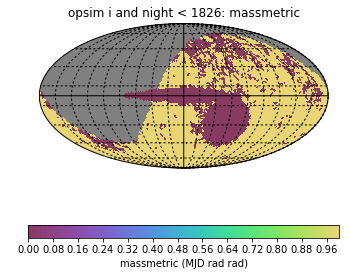

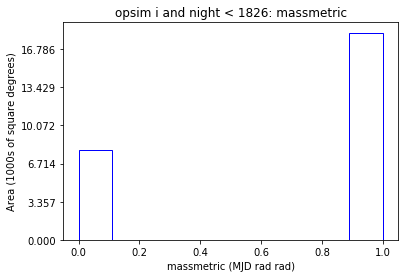

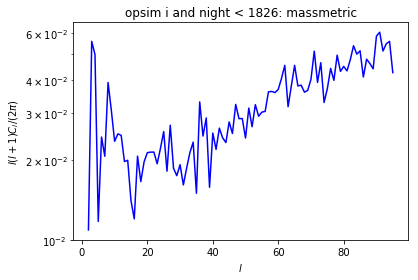

In [17]:
# Run the queries
bg.runAll()

# Create the plots
bg.plotAll(closefigs=False)

In [18]:
dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
opsdb = db.OpsimDatabase(dir+'astro_lsst_01_1064_sqlite.db')
outDir = 'notebook_output'

astro_lsst_01_1064.sqlite.db is the "hacked" rolling cadence from the SN group and Rahul Biswas.

In [19]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
nyears = 5.
mass = 30.
sql = 'filter="i" and night < %i' % (365.25*nyears)

In [20]:
# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=mass)

# Let's look at the metric results in the galactic coordinate fram
slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=32)

plotDict_detectable = {'colorMin':0,'colorMax': 1.}
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)
# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'detectable':bundle_detectable}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


Querying database with constraint filter="i" and night < 1826
Found 242812 visits
Running:  ['detectable']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter="i" and night < 1826 constraint now.
monopole: 0.0228282  dipole: lon: 95.8538, lat: -58.2559, amp: 0.0142831
Plotting complete.


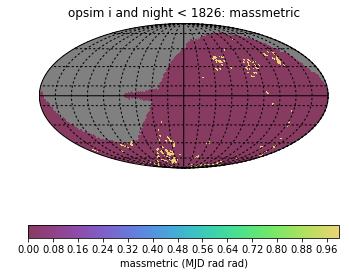

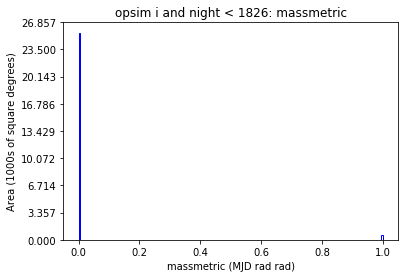

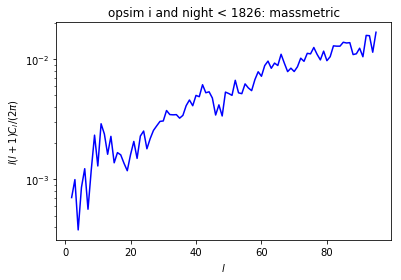

In [21]:
# Run the queries
bg.runAll()

# Create the plots
bg.plotAll(closefigs=False)